# Inverse Modelling of a Synthetic Glacier

This notebook goes through the process of using the inverse method to find a conductivity model from synthetic magnetic flux data. The notebook can be used completely on its own as long as csv file of data is available, the forward model notebook contains the full process of finding the forward model and simulating data.

The notebook is divided into 4 steps:
1. Load in the data from the forward model csv
2. Define the survey and create the mesh and reference model
3. inverse modelling (define the problems to solve)
4. plot the results (predicted and observed data, recovered and true model)

In [1]:
#import modules
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from discretize import TensorMesh
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    data as simpeg_data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
plt.rcParams.update({"font.size": 16, "lines.linewidth": 2, "lines.markersize": 8})

## Step 1: Load in Data

Load in the data that we generated in `forward_model.ipynb` and add in the noise that we want 

In [2]:
# Load field data
data = pd.read_csv("forward_data.csv")
data_object = data[["time", "d_obs"]]
times = data["time"]
dmodel = data["d_obs"]*(10**9) #in nano tesla
dobs = dmodel + 0.05*np.random.randn(len(times))

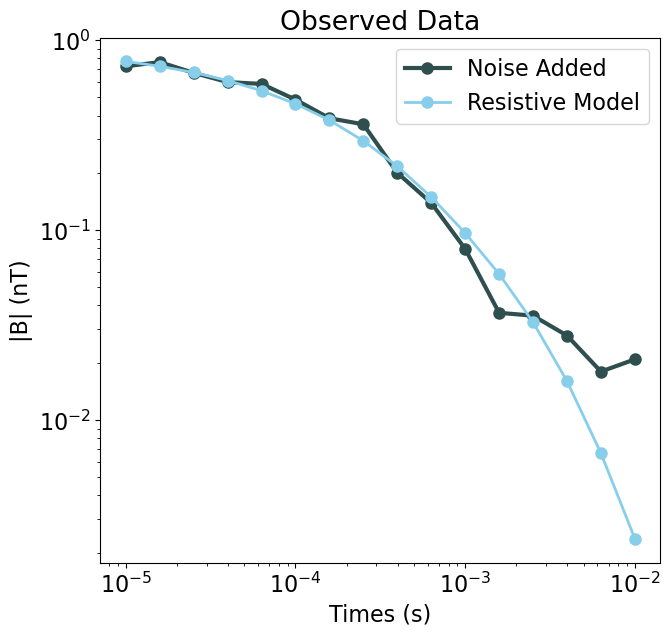

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "darkslategrey", marker = "o", lw=3, label = "Noise Added")
ax.loglog(times, np.abs(dmodel), color = "skyblue", marker = "o", label = "Resistive Model")
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (nT)")
ax.set_title("Observed Data")
ax.legend()

## Step 2: Define Survey

Redefine survey just as in the previous notebook. 

We've forced the data to have 5% noise, and I have set the "supposed" noise to be 7%, which will hopefully capture the true model quite well but if not I'll play around a bit.

In [4]:
# Source loop geometry
source_location = np.array([0.0, 0.0, 20.0])
source_orientation = "z"  # "x", "y" or "z"
source_current = 500  # A
source_radius = np.sqrt(499/np.pi)  #total loop area from 

# Receiver geometry
receiver_location = np.array([0.0, 0.0, 35.0])
receiver_orientation = "z"  # "x", "y" or "z"

# Receiver list
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Define the source waveform.
eps = 6.5*(1e-6)
ramp_on = np.r_[-0.0008, -0.0008 + eps]
ramp_off = np.r_[-eps, 0.0]
waveform = tdem.sources.TrapezoidWaveform(
    ramp_on=ramp_on, ramp_off=ramp_off
)

# Sources
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Survey
survey = tdem.Survey(source_list)

### Side Track to Define a Mesh

Estimate the diffusion distances (equation 1) using a reference conductivity ($\sigma$ the conductivity of the surrounding rock). Then define the mesh layers, the 1st layer depth is 1m and it will increase by 1.5m until the total depth (600m) is reached.

 $$ (1) \space d_{min/max} = 1250 * \sqrt{\frac{t_{min/max}}{\sigma}}$$

In [10]:
#estimate diffusion distances
estimate = 1e-3
dmin = 1250 * np.sqrt(times.min()/estimate) #minimum diffusion distance
dmax = 1250 * np.sqrt(times.max()/estimate) #maximum diffusion distance

#define mesh layers
depth_min = 1
depth_max = 600 #total depth, from reference paper
depth_factor = 1.1 # rate of increase of layers

layer_thicknesses = [depth_min]
counter = 0
glacier_index = []
rock_index = []
wet_index = []
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(depth_factor * layer_thicknesses[-1])
    if np.sum(layer_thicknesses) < 200:
        glacier_index.append(counter)
    if np.sum(layer_thicknesses) >300:
        rock_index.append(counter)
    else:
        wet_index.append(counter)
    counter += 1
n_layers = len(layer_thicknesses) + 1  # Number of layers

In [11]:
#define the mesh
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 45 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     45       -712.88         -0.00      1.00     60.24    1.10




In [13]:
#I'm making the starting model the background geologic value
log_conductivity_map = maps.ExpMap(nP=n_layers) #define map

#find where the mesh 

starting_conductivity_model = np.ones(n_layers)
starting_conductivity_model[glacier_index] = 10**-4 #estimate of the depth of the glacier
starting_conductivity_model[wet_index] = 10**-1
starting_conductivity_model[rock_index] = 10**-3
starting_conductivity_model = np.log(starting_conductivity_model)
reference_conductivity_model = starting_conductivity_model.copy()

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

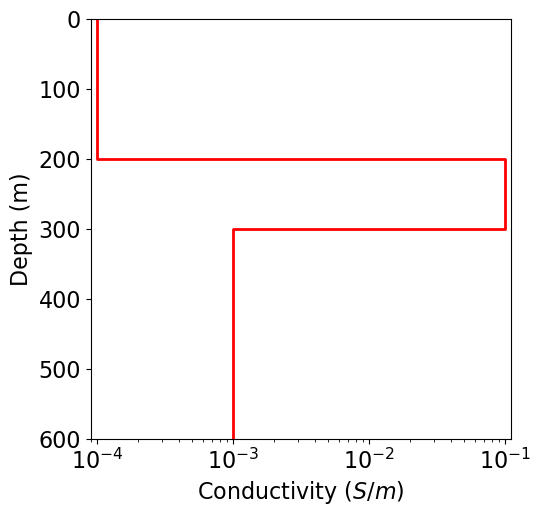

In [24]:
#plot reference model
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
reference_layers = np.r_[200, 100, 300]
ref_model = np.r_[10**-4, 10**-1, 10**-3]
plot_1d_layer_model(reference_layers,ref_model, ax=ax1, color="red")
plt.xlabel("Conductivity $(S/m)$")
plt.show()

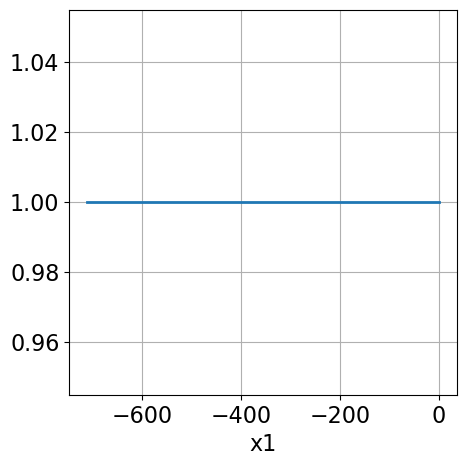

In [15]:
#plot the mesh and the starting model
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
regularization_mesh.plot_grid(ax=ax)
plt.show()

# Step 3: Inverse Modelling
1. Define the Forward Model just as in `forward_model.ipynb`
2. Define the data misfit using an L2 norm, we weight the misfit by the reciprocal of the uncertainties (that we've defined)
3. Define the model misfit which in this case is a regularisation norm, uses the tensor mesh from above.
4. Define the optimisation problem that we want to solve.
5. Define the inversion problem that we want to solve.

In [16]:
#forward model and misfits
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)
#define the inversion problem
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [17]:
#Inversion directives
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, starting_beta, beta_schedule, target_misfit]

In [18]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_conductivity_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


C:\Users\jrobs\anaconda3\envs\eosc454\Lib\site-packages\simpeg\simulation.py:197: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
C:\Users\jrobs\anaconda3\envs\eosc454\Lib\site-packages\pymatsolver\wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.52e-15  3.27e+03  4.99e+03  3.27e+03    4.23e-05      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.0000e+00 <= tolX*(1+|x0|) = 0.0000e+00
1 : |proj(x-g)-x|    = 4.2329e-05 <= tolG          = 1.0000e-01
1 : |proj(x-g)-x|    = 4.2329e-05 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =      0
------------------------- DONE! -------------------------


## Step 4: Plot the Recovered Model and Predicted Data

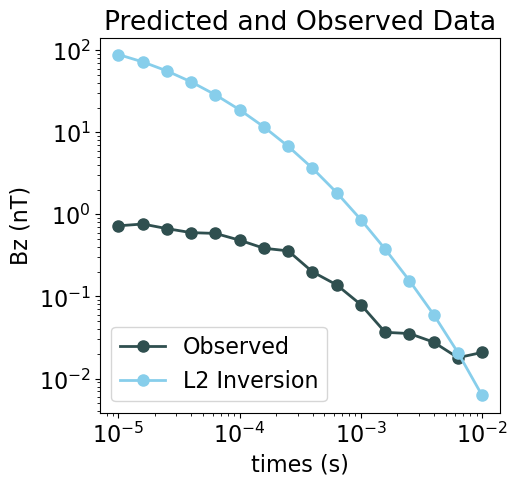

In [25]:
#plot the predicted data
dpred_L2 = simulation_L2.dpred(recovered_model_L2)*10**9

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs),marker =  "o", color = "darkslategray")
ax1.loglog(times, np.abs(dpred_L2), marker = "o", color = "skyblue")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (nT)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="lower left")
plt.show()

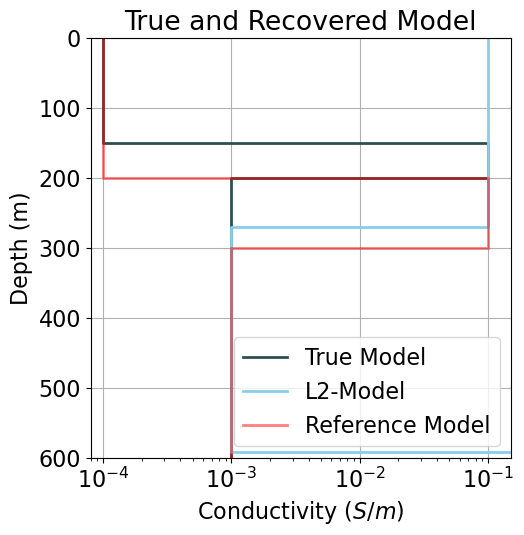

In [26]:
# Plot true model and recovered model
ice_sigma = 1/10**4 #taken from reference paper
nonice_sigma = 1/10**3
wet_sigma = 1/10**1 
sigmas = np.r_[ice_sigma, nonice_sigma, nonice_sigma]
true_conductivities = np.r_[ice_sigma, wet_sigma, nonice_sigma]

#layer thickness
glacier_z = 150 #from reference paper
total_z = 350
non_glacier_z = total_z - glacier_z

thickness = np.r_[glacier_z,non_glacier_z]
true_layers = np.r_[glacier_z, 50, 400]

fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_conductivities, ax=ax1, color="darkslategray")
plot_1d_layer_model(
    layer_thicknesses, log_conductivity_map * recovered_model_L2, ax=ax1, color="skyblue"
)
plot_1d_layer_model(reference_layers, ref_model, ax=ax1, color="red", alpha = 0.5)
ax1.grid()
plt.title("True and Recovered Model")
ax1.set_xlabel(r"Conductivity ($S/m$)")
x_min, x_max = true_conductivities.min(), true_conductivities.max()
ax1.set_xlim(0.8 * x_min, 1.5 * x_max)
ax1.set_ylim([np.sum(true_layers), 0])
ax1.legend(["True Model", "L2-Model", "Reference Model"])
plt.show()